In [1]:
#% matplotlib inline

from datetime import datetime 
import h5py
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
cmap = cm.get_cmap('Blues')
import random
from scipy import signal, cluster, stats
from multiprocessing import Pool
import scipy as sp
from scipy import linalg

from PIL import Image
import cairosvg

target_user = 'Vlasits'

restriction_str = 'experimenter = "{}"'.format(target_user)

In [2]:
#pull data from hdf5 file
data = pd.read_hdf('Data/Fig8.hdf5', 'data_cluster_field')


In [3]:
# determine the location of the maximum response in y and t for each receptive field
max_t = np.zeros(data.shape[0])
max_y = np.zeros(data.shape[0])
quality_check = np.zeros(data.shape[0])

center_pixel_list = data.index.to_frame(index=False)['center_pixel_id']

for idx, center_pixel in enumerate(center_pixel_list):
    current_frame = data['spl'].loc[center_pixel]
    current_frame = current_frame[50:240,:]
    index_max = np.unravel_index(np.argmax(current_frame, axis=None), current_frame.shape)
    max_y[idx] = index_max[1]
    max_t[idx] = index_max[0]+50
    if 160 < index_max[0]+50 < 250:
        quality_check[idx] = 1

# data['quality'] = quality_check

data['peak_y'] = max_y

data['peak_t'] = max_t

In [4]:
# determine the location of the maximum response in y and t for each receptive field
max_t_early = np.zeros(data.shape[0])
max_y_early = np.zeros(data.shape[0])
max_t_late = np.zeros(data.shape[0])
max_y_late = np.zeros(data.shape[0])
quality_check = np.zeros(data.shape[0])
early_start = np.int(20)
early_end = np.int(80)

late_start = np.int(210)
late_end = np.int(234) #time of impulse

center_pixel_list = data.index.to_frame(index=False)['center_pixel_id']

for idx, center_pixel in enumerate(center_pixel_list):
    current_frame = data['spl'].loc[center_pixel]
    current_frame = current_frame[early_start:early_end,:]
    index_max = np.unravel_index(np.argmax(current_frame, axis=None), current_frame.shape)
    max_y_early[idx] = index_max[1]
    max_t_early[idx] = index_max[0]+early_start
    
#     if 20 < index_max[0]+early_start < early_end:
#         quality_check[idx] = 1
    
    current_frame = data['spl'].loc[center_pixel]
    current_frame = current_frame[late_start:late_end,:]
    index_max = np.unravel_index(np.argmax(current_frame, axis=None), current_frame.shape)
    max_y_late[idx] = index_max[1]
    max_t_late[idx] = index_max[0]+late_start
    if 4 < index_max[1] < 12:
        quality_check[idx] = 1
    
    


data['quality'] = quality_check

data['peak_y_early'] = max_y_early
data['peak_t_early'] = max_t_early
data['peak_y_late'] = max_y_late
data['peak_t_late'] = max_t_late

data_highq = data[data['quality']>0]

# clustering

In [5]:
splines = np.asarray(data_highq['spl'])
spline_array = np.zeros((splines.shape[0], splines[0].shape[0]*splines[0].shape[1]))
spline_array_cropped = np.zeros((splines.shape[0], 242*14))

for i, spline in enumerate(splines):
    current_spline = spline
    current_spline_flat = current_spline.flatten(order='F')
    spline_array[i,:] = current_spline_flat
    
    current_spline_cropped = spline[20:-50,2:16]
    current_spline_cropped_flat = current_spline_cropped.flatten()#order='F'
    spline_array_cropped[i,:] = current_spline_cropped_flat

# spline_array_cropped = spline_array[:, 300:-300]  

In [6]:
zscored_spline_array = ((spline_array_cropped.T-np.mean(spline_array_cropped, axis=1))/np.std(spline_array_cropped, axis=1)).T

In [7]:
threshold = 1
quality_mask = np.where(np.amax(np.abs(zscored_spline_array), axis=1)>threshold)

In [8]:
#pull from hdf5 file
#read hdf5 file for this notebook
f1 = h5py.File("Data/Fig8.hdf5", "r")

#get the data for plotting the sd image
cluster_assignments = np.array(f1['cluster_assignments_example_field_correct'])
f1.close()

In [9]:
data_highq['new_cluster_assignment'] = cluster_assignments

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


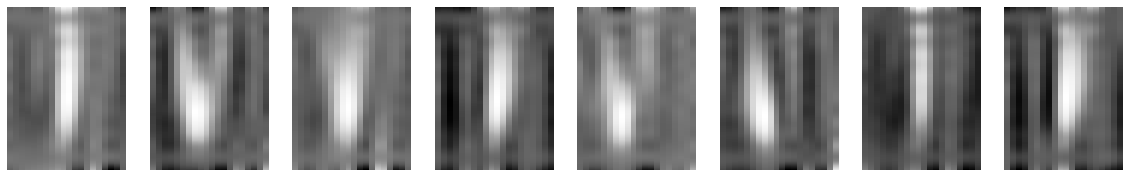

In [10]:
n_clusters = data_highq['new_cluster_assignment'].unique().shape[0]

fig, ax = plt.subplots(1, n_clusters, figsize=(20, 3))


for i in range(n_clusters):
    
    ax[i].imshow(data_highq['spl'][data_highq['new_cluster_assignment']==i].mean(), aspect='auto', cmap='Greys_r')
    ax[i].axis('off')

# Figpath = 'Fig_temp/'
# savename = Figpath+"GCamp_Spline_Noise_cluster_avg_filters.pdf"
# plt.savefig(savename, transparent=False, bbox_inches='tight')

In [11]:
#pull from hdf5 file
#read hdf5 file for this notebook
f1 = h5py.File("Data/Fig8.hdf5", "r")

#get the data for plotting the sd image
roi_mask = np.array(f1['roimask_cluster_field'])
f1.close()

In [12]:
labels = np.array(data_highq['new_cluster_assignment'])
SignPxLoc = np.zeros((2, labels.shape[0]))
for i, roi in enumerate(data_highq.index):
    index = np.where(roi_mask == -(roi))
    SignPxLoc[0, i] = int(index[0])
    SignPxLoc[1, i] = int(index[1])

ClusterMapSign = np.zeros((roi_mask.shape[0], roi_mask.shape[1]))
for i in range(SignPxLoc[0].shape[0]):
    ClusterMapSign[int(SignPxLoc[0][i]), int(SignPxLoc[1][i])] = labels[i]+1

In [13]:
# current_palette = sns.color_palette('colorblind')
current_palette = sns.color_palette("hls", n_clusters)

white = (1, 1, 1)

current_palette = list(current_palette)

current_palette.insert(0, white)
n_bins =n_clusters

# current_palette = current_palette[:n_bins]

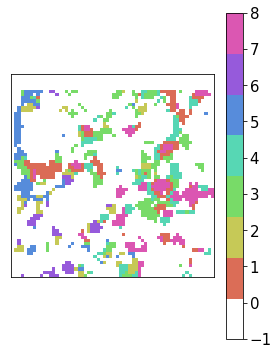

In [14]:
cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, current_palette, N=n_bins)
plt.figure(figsize=(10,6))

plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'axes.titlesize': 15})
plt.rcParams.update({'axes.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'ytick.labelsize':15})
# plt.imshow((-1)*ClusterMapSign[3:,:], cm)

plt.subplot(1,2,1)
plt.imshow(ClusterMapSign, cm, vmin=-1, vmax=8)
plt.xticks([])
plt.yticks([])

cbar = plt.colorbar()

# plt.subplot(1,3,2)
# plt.imshow(roi_mask, cmap="Greys", vmin=0, vmax=1)
# plt.xticks([])
# plt.yticks([])

# plt.subplot(1,2,2)
# plt.imshow(std, cmap='gray', vmax=70)
# plt.xticks([])
# plt.yticks([])

# Figpath = 'Fig_temp/'
# savename = Figpath+"GCamp_Spline_Noise_cluster_map.pdf"
# plt.savefig(savename, transparent=False, bbox_inches='tight')

plt.show()


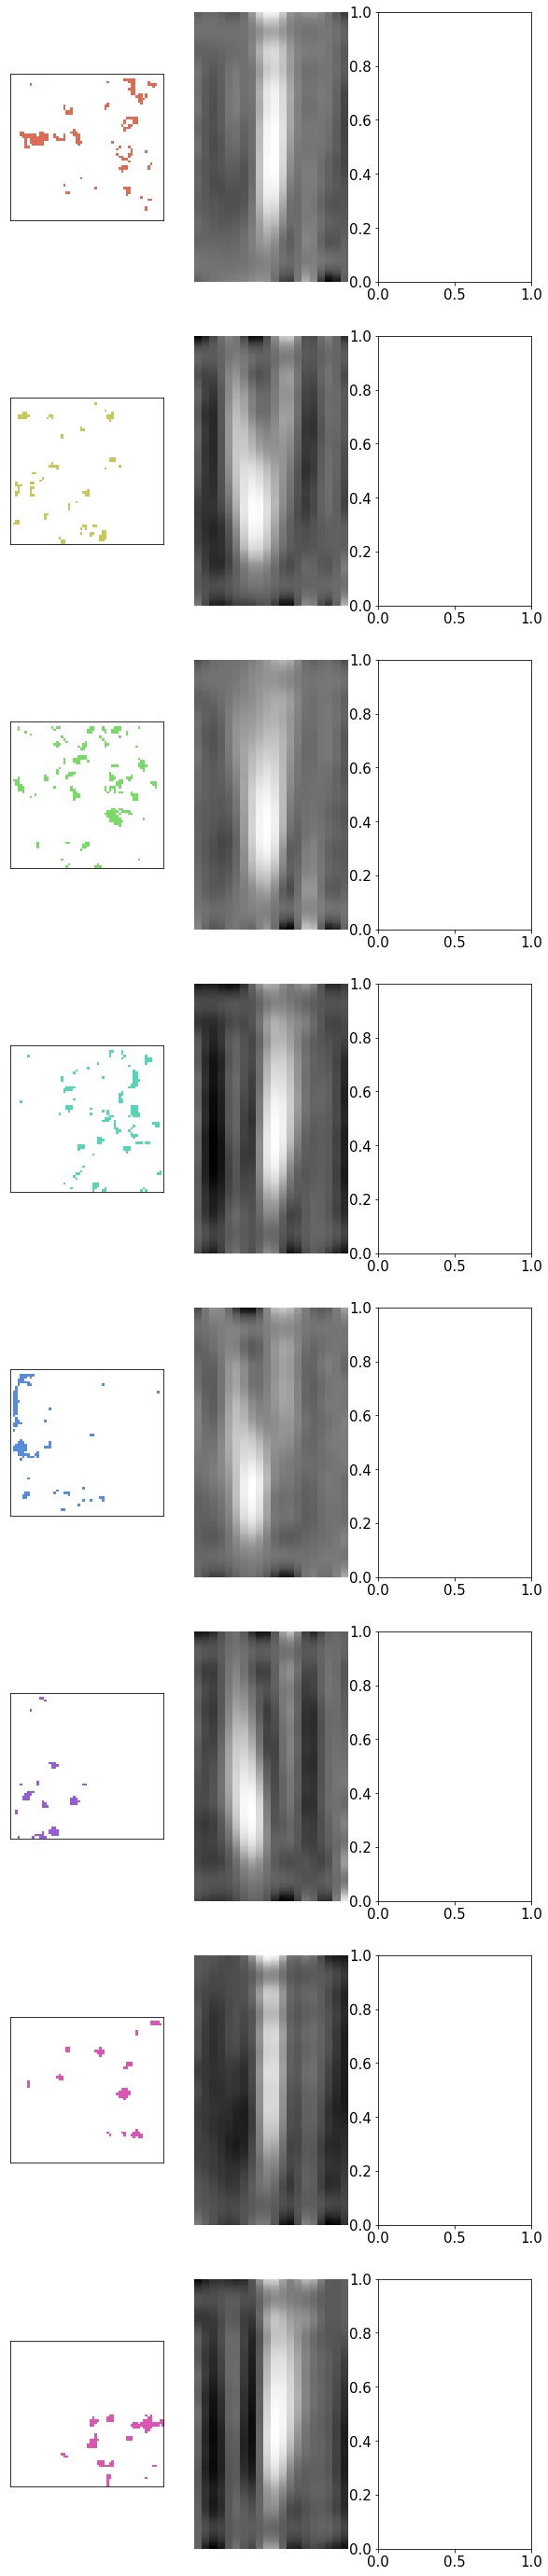

In [15]:
fig, ax = plt.subplots(n_clusters, 3, figsize=(10, 50))

for i in range(n_clusters):

    onecluster = i+1

    cluster_loc = np.where(ClusterMapSign == onecluster, ClusterMapSign, 0)
    ax[i, 0].imshow(cluster_loc[3:,:], cmap=cm, vmin=-1, vmax=8)
    ax[i, 0].set_yticklabels([])
    ax[i, 0].set_xticklabels([])
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    
    ax[i, 1].imshow(data_highq['spl'][data_highq['new_cluster_assignment']==i].mean(), aspect='auto', cmap='Greys_r')
    ax[i, 1].axis('off')
    
#     mask = np.array(data_highq['new_cluster_assignment']==i)
#     line_x = np.stack((np.array(data_highq['peak_y_early'][mask]*25), np.array(data_highq['peak_y_late'][mask]*25)), axis=1)
#     line_y = np.stack((np.array(data_highq['peak_t_early'][mask]*real_time_lag/time_points), 
#                   np.array(data_highq['peak_t_late'][mask]*real_time_lag/time_points)), axis=1)
#     ax[i, 2].plot(line_x, line_y, color='k', alpha=0.5)

#     ax[i,2].plot([data_highq['peak_y_early'][data_highq['new_cluster_assignment']==i]*25, data_highq['peak_y_late'][data_highq['new_cluster_assignment']==i]*25], 
#                  [data_highq['peak_t_early'][data_highq['new_cluster_assignment']==i]*real_time_lag/time_points, data_highq['peak_t_late'][data_highq['new_cluster_assignment']==i]*real_time_lag/time_points], 
#                  marker='None', alpha=0.1, linewidth=1)
#     ax[i,2].set_xlim([0, 500])
#     ax[i,2].set_ylim([0.5, 0])

    
    
# Figpath = 'Fig_temp/'
# savename = Figpath+"GCamp_individual_clusters_RFs.pdf"
# plt.savefig(savename, transparent=False, bbox_inches='tight')

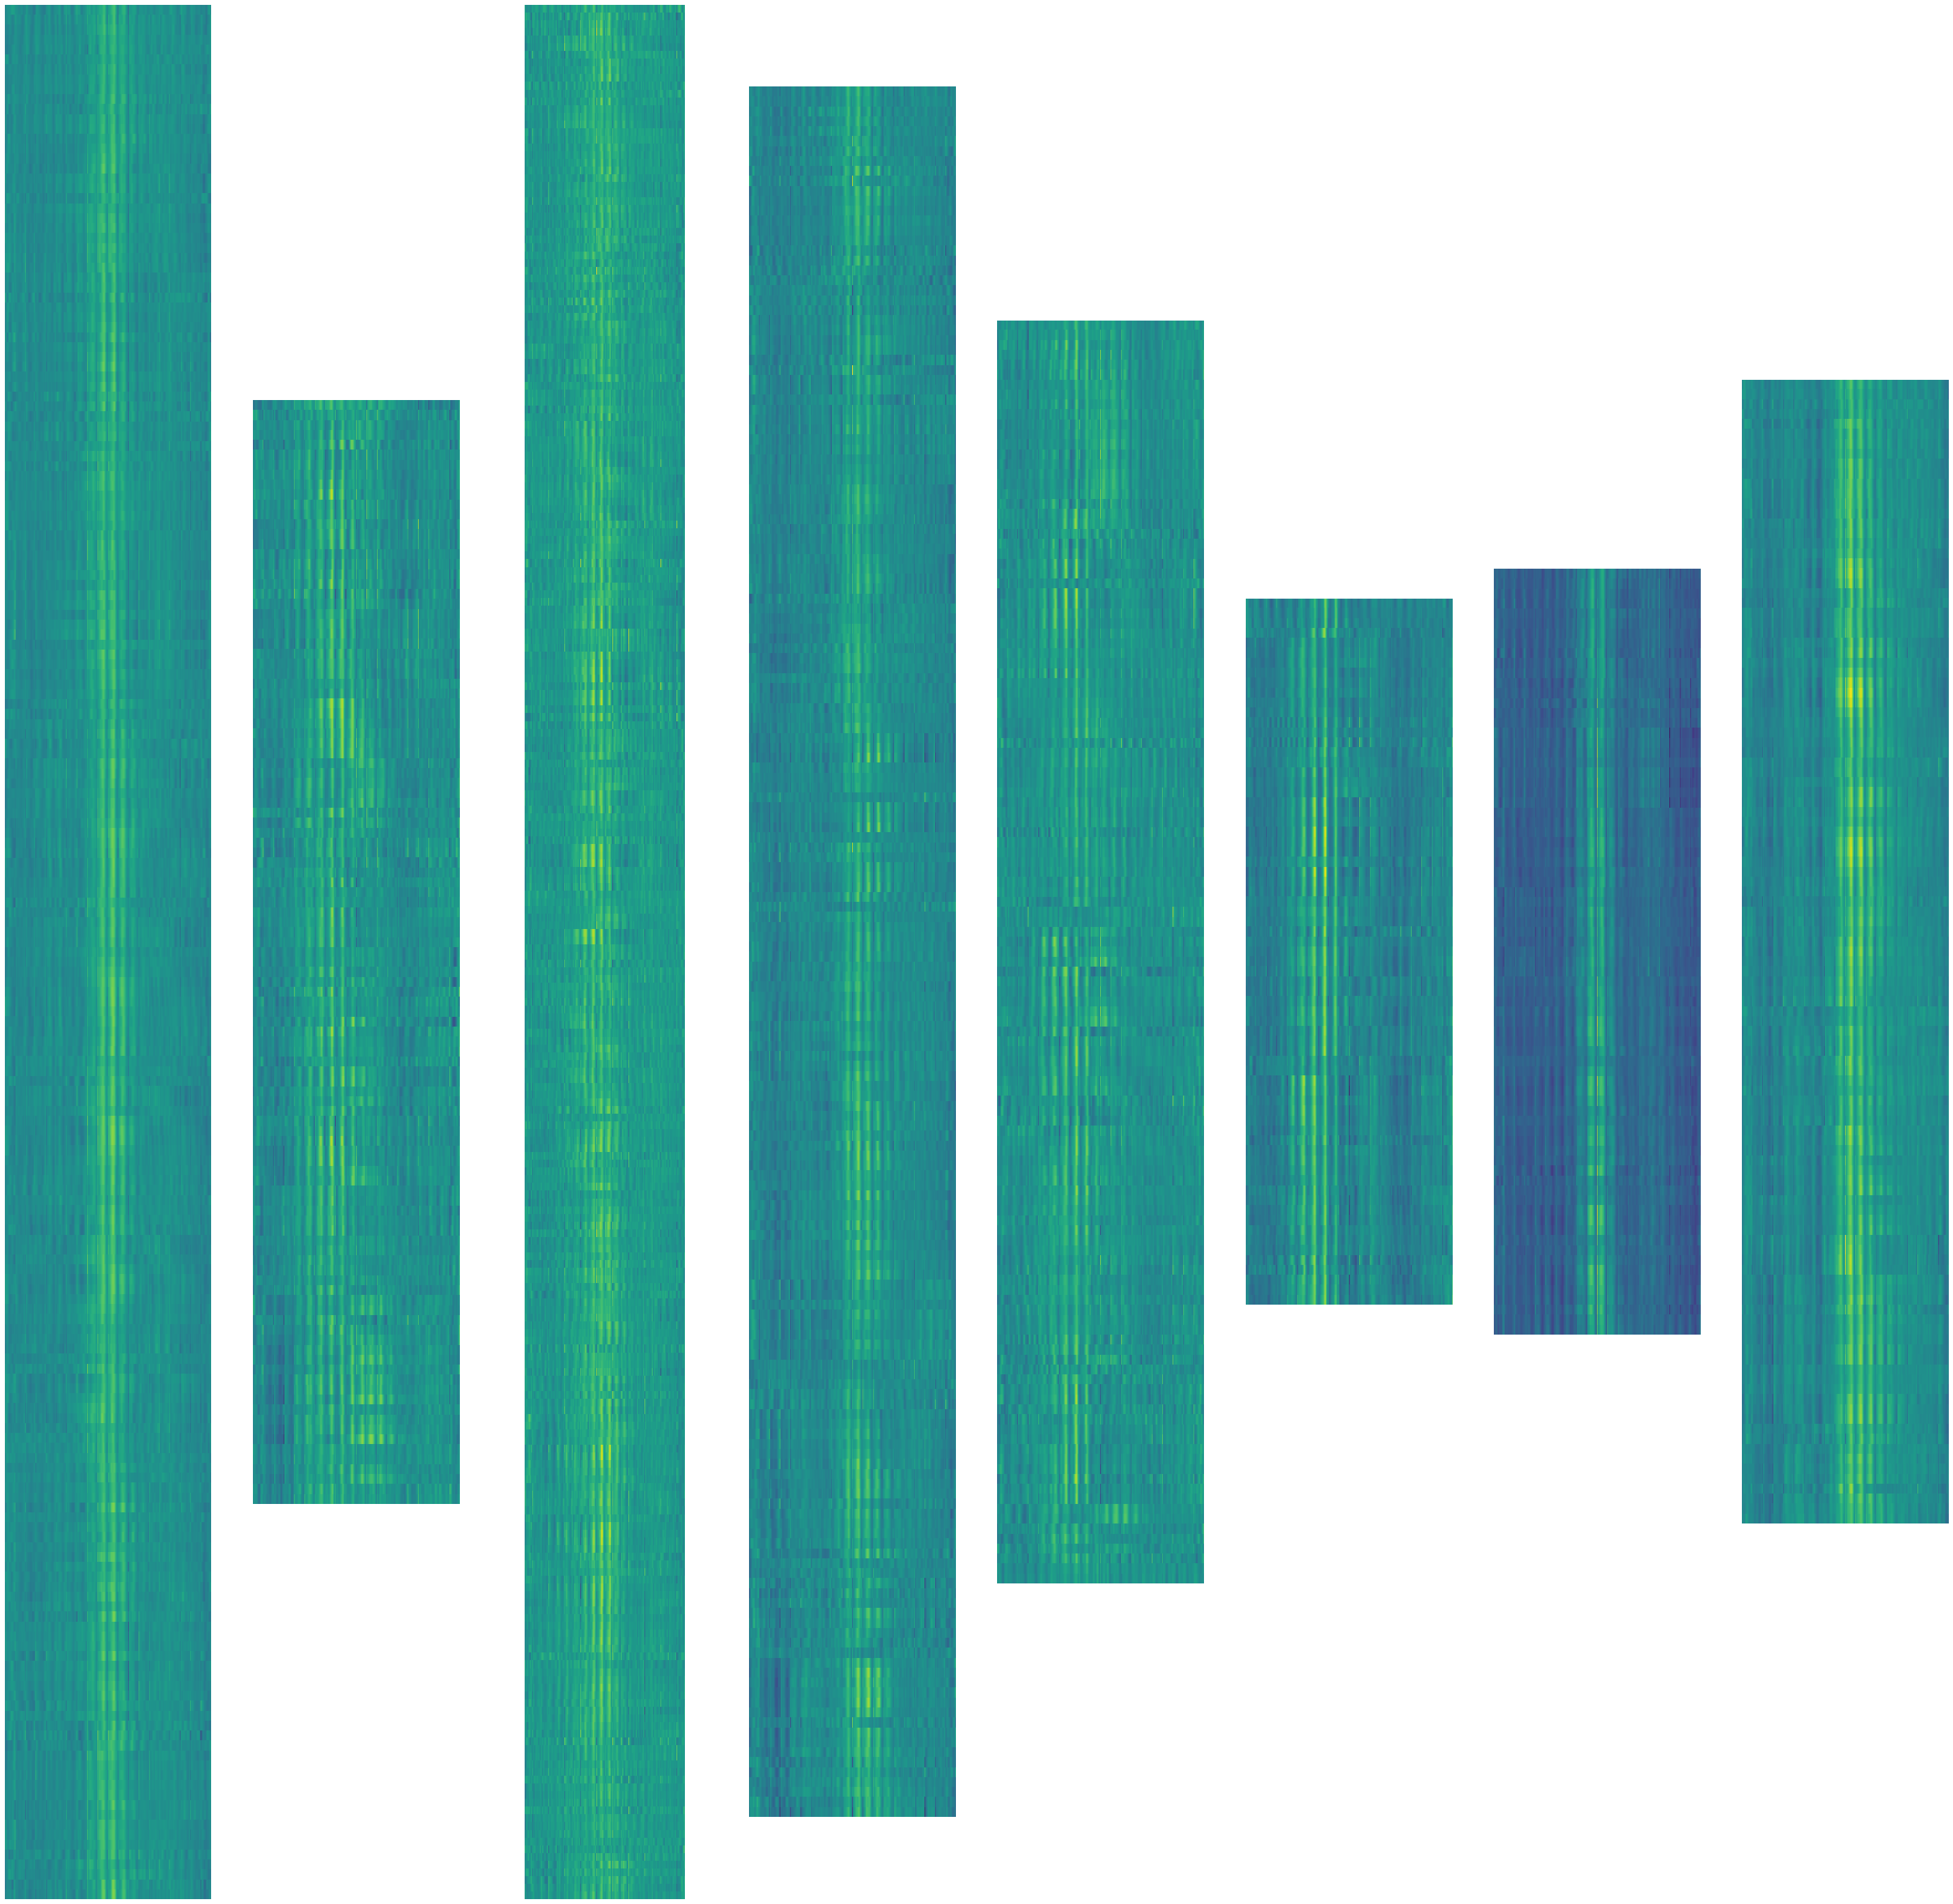

In [16]:
fig, ax = plt.subplots(1, n_clusters, figsize=(50, 50))
for i in range(n_clusters):
    
    ax[i].imshow(spline_array[quality_mask[0],:][data_highq['new_cluster_assignment']==i], cmap='viridis', aspect=300,) 
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].axis('off')
    

# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

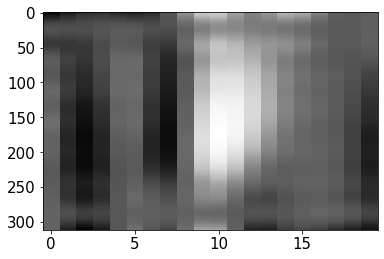

In [17]:
cluster_num = onecluster

plt.imshow(data_highq['spl'][data_highq['new_cluster_assignment']==cluster_num-1].mean(), aspect='auto', cmap='Greys_r')

# Figpath = 'Fig_temp/'
# savename = Figpath+"GCamp_Spline_Noise_cluster_avg_filter_"+str(cluster_num)+".pdf"
# plt.savefig(savename, transparent=False, bbox_inches='tight')